# Voltage-Clamp Step Membrane Test

## Environment Setup

In [1]:
import os
import ltspice
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import scipy.optimize
np.set_printoptions(suppress=True)

HERE = os.path.abspath(os.getcwd())
simFilePath = os.path.abspath(f"{HERE}/../models/single-electrode-memtest/memtest.raw")
assert os.path.isfile(simFilePath)

## Read, Scale, and Interpolate Model Data

We can read data right out of the LTSpice simulation file, but it is not evenly spaced.

In [2]:
l = ltspice.Ltspice(simFilePath)
l.parse()

#print(", ".join(l.getVariableNames()))
timesOriginal = l.getTime() * 1e3  # ms
Vcell = l.getData('V(vm)') * 1e3  # mV
Vcommand = l.getData('V(vc)') * 1e3  # mV
Iclamp = l.getData('I(Rf)') * 1e12  # pA

print(timesOriginal)

[  0.        0.10205   0.20445 ... 104.9596  104.9999  105.     ]


We will use Scipy's interpolation module to create a signal with evenly-spaced points

In [3]:
# interpolate data for 20 kHz sample rate
f = scipy.interpolate.interp1d(timesOriginal, Iclamp)
pointCount = int((timesOriginal[-1] - timesOriginal[0]) * 20) + 1
times = np.linspace(timesOriginal[0], timesOriginal[-1], pointCount)
Iclamp = f(times)
print(times)

[  0.     0.05   0.1  ... 104.9  104.95 105.  ]


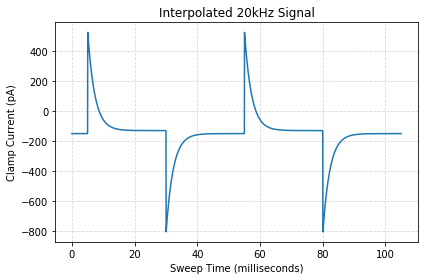

In [4]:
plt.figure(figsize=(6, 4))
plt.grid(ls='--', alpha=.5)
plt.title("Interpolated 20kHz Signal")
plt.plot(times, Iclamp)
plt.xlabel("Sweep Time (milliseconds)")
plt.ylabel("Clamp Current (pA)")
plt.tight_layout()
plt.savefig(f"{HERE}/mt1.png")
plt.show()

## Fix Single-Point Interpolation Error

There is a single bad data point where there is a sharp transition due to how the interpolation was performed. This error will not exist in real recorded data. I'll fix this manually.

In [5]:
Iclamp[100] = Iclamp[101] + (Iclamp[101] - Iclamp[102])
Iclamp[600] = Iclamp[601] + (Iclamp[601] - Iclamp[602])

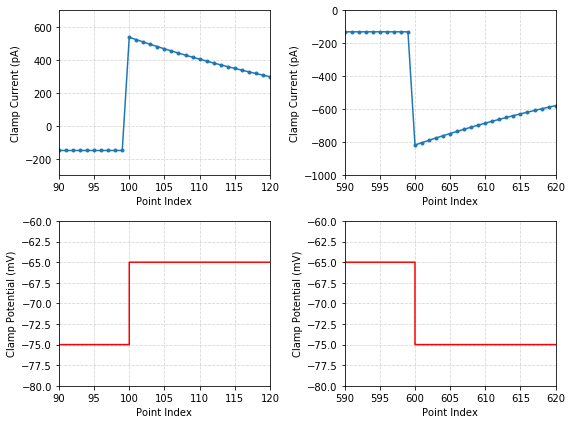

In [6]:
plt.figure(figsize=(8, 6))

plt.subplot(221)
plt.grid(ls='--', alpha=.5)
plt.plot(Iclamp, '.-')
plt.xlabel("Point Index")
plt.ylabel("Clamp Current (pA)")
plt.axis([90, 120, -300, 700])

plt.subplot(223)
plt.grid(ls='--', alpha=.5)
plt.plot(timesOriginal * 20, Vcommand, 'r-')
plt.xlabel("Point Index")
plt.ylabel("Clamp Potential (mV)")
plt.axis([90, 120, -80, -60])

plt.subplot(222)
plt.grid(ls='--', alpha=.5)
plt.plot(Iclamp, '.-')
plt.xlabel("Point Index")
plt.ylabel("Clamp Current (pA)")
plt.axis([590, 620, -1000, 0])

plt.subplot(224)
plt.grid(ls='--', alpha=.5)
plt.plot(timesOriginal * 20, Vcommand, 'r-')
plt.xlabel("Point Index")
plt.ylabel("Clamp Potential (mV)")
plt.axis([590, 620, -80, -60])


plt.tight_layout()
plt.show()

## Isolate Curve of Interest

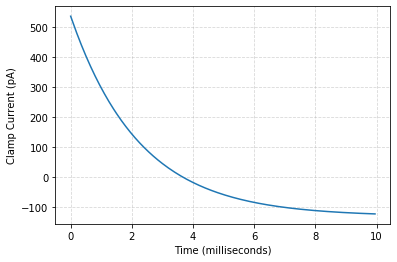

In [7]:
curve = Iclamp[100:300]
curveTimes = times[:len(curve)]

plt.figure(figsize=(6, 4))
plt.grid(ls='--', alpha=.5)
plt.plot(curveTimes, curve, '-')
plt.xlabel("Time (milliseconds)")
plt.ylabel("Clamp Current (pA)")
plt.savefig(f"{HERE}/mt1.png")
plt.show()

## Fit an Exponential Curve

In [8]:
def monoExp(t, m, tau, b):
    return m * np.exp(-t/tau) + b

(m, tau, b), cv = scipy.optimize.curve_fit(monoExp, curveTimes, curve, (2000, .1, 50))
print(f"I = {m:.03f} * exp(-t / {tau:.03f}) + {b:.03f}")

I = 667.070 * exp(-t / 2.250) + -129.996


## Prepare Variables (with proper units)

In [9]:
Iss = b*1e-12
print(f"Iss: {Iss*1e12:.03f} pA")

IssBefore = Iclamp[99]*1e-12
print(f"IssBefore: {IssBefore*1e12:.03f} pA")

dIss = Iss - IssBefore
print(f"dIss: {dIss*1e12:.03f} pA")

Ipeak = (m + b)*1e-12
print(f"Ipeak: {Ipeak*1e12:.03f} pA")

dI = Ipeak - IssBefore
print(f"dI: {dI*1e12:.03f} pA")

dV = 10e-3
print(f"dV: {dV*1e3:.03f} mV")

tau = tau*1e-3
print(f"ClampTau: {tau*1e3:.03f} ms")

Iss: -129.996 pA
IssBefore: -150.015 pA
dIss: 20.019 pA
Ipeak: 537.074 pA
dI: 687.089 pA
dV: 10.000 mV
ClampTau: 2.250 ms


## Calculate Ra

In [10]:
# E = I * R
# ΔV = ΔI * R
# R = ΔV / ΔI
# Ra = ΔV / (Ipeak - Iss)
# Ra = ΔV / I0

Ra = dV / dI
print(f"Ra: {Ra*1e-6:f} MΩ")

Ra: 14.554154 MΩ


## Calculate Rm

LTSpice warning: if grounding Rm through a voltage source make sure its series resistance is large (999G)

In [11]:
# V = I * R
# I = V / R
# ΔI = ΔV / R
# R * ΔI = ΔV
# (Ra + Rm) * ΔI = ΔV
# Ra * ΔI + Rm * ΔI = ΔV
# Rm * ΔI = ΔV - Ra * ΔI
# Rm = (ΔV - Ra * ΔI) / ΔI

Rm = (dV - Ra * dIss) / dIss
print(f"Rm: {Rm*1e-6:f} MΩ")

Rm: 484.963081 MΩ


## Calculate Cm

In [12]:
# Ram = Ra and Rm in parallel
# Ram = 1/(1/Ra + 1/Rm)
Ram = 1/(1/Ra + 1/Rm)
print(f"Ram: {Ram*1e-6:f} MΩ")

# tau = Ram * Cm
Cm = tau / Ram
print(f"Cm: {Cm*1e12:f} pF")

Ram: 14.130098 MΩ
Cm: 159.201908 pF


## Summary

Metric | Model | Measured | Error
---|---|---|---
Ra|15 MΩ|14.55 MΩ|3%
Rm|500 MΩ|484.96 MΩ|3%
Cm|150 pF|159.20 pF|6%